In [9]:
# you can call a function "on device"
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel(device=True)
def do_a_thing(x, y):
    return (y, x)
    
@jit.rawkernel()
def do_more_things(x, y, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        (x[i], y[i]) = do_a_thing(x[i], y[i])

size = 10
x = cp.random.random(size, dtype=np.float32)
y = cp.random.random(size, dtype=np.float32)

print(x)
print(y)

do_more_things((128,),(1024,),(x, y, size))

print(x)
print(y)


[0.73879254 0.36430386 0.5560938  0.13465711 0.49230078 0.8651738
 0.01775549 0.39530468 0.26143515 0.01097945]
[0.96701926 0.31582886 0.45942357 0.02675973 0.44531643 0.38146228
 0.26420838 0.38977566 0.22158593 0.36414465]
[0.96701926 0.31582886 0.45942357 0.02675973 0.44531643 0.38146228
 0.26420838 0.38977566 0.22158593 0.36414465]
[0.73879254 0.36430386 0.5560938  0.13465711 0.49230078 0.8651738
 0.01775549 0.39530468 0.26143515 0.01097945]


In [26]:
# python float scalar type doesn't work, use numpy type
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel()
def scalar_multiply(a, m, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        a[i] = a[i] * m

size = 5
a = cp.random.random(size, dtype=np.float32)

print(a)
scalar_multiply((128,),(1024,),(a, np.float32(5.0), size))
print(a)
scalar_multiply((128,),(1024,),(a, 5.0, size))
print(a)

[0.17959814 0.42873758 0.77541053 0.8213136  0.8284943 ]
[0.8979907 2.143688  3.8770528 4.1065683 4.1424713]
[0. 0. 0. 0. 0.]


In [117]:
%%time
x = cp.random.random(10000000, dtype=np.float32) * 2

CPU times: user 153 µs, sys: 87 µs, total: 240 µs
Wall time: 176 µs


In [102]:
%%time
y = cp.random.uniform(0, 2, 10000000, dtype=np.float32)

CPU times: user 236 µs, sys: 0 ns, total: 236 µs
Wall time: 181 µs


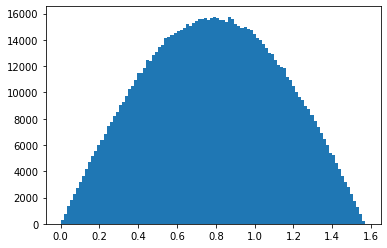

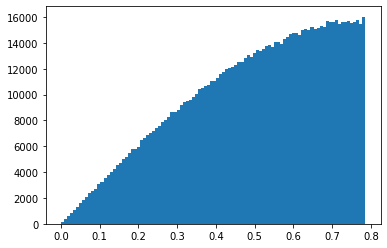

In [11]:
# i'm losing my mind
import numpy as np
import matplotlib.pyplot as plt

size = 1000000
x = np.arccos(2 * np.random.random(size) - 1) / 2
y = np.arccos(np.random.uniform(-1, 1, size))/2
plt.hist(x, bins=100);
plt.show()
plt.hist(y, bins=100);

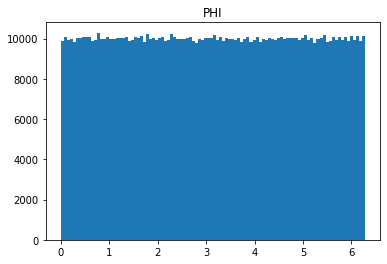

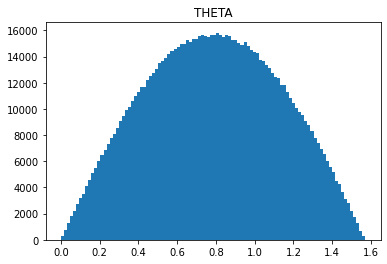

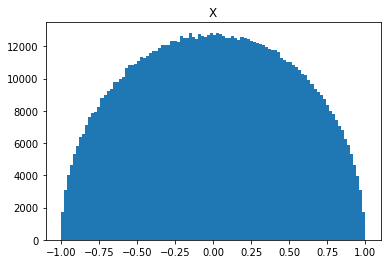

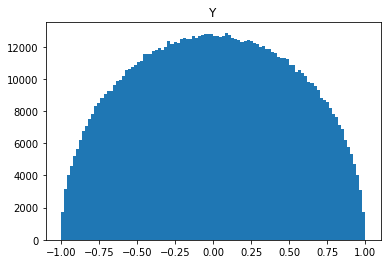

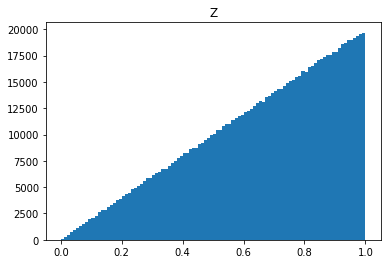

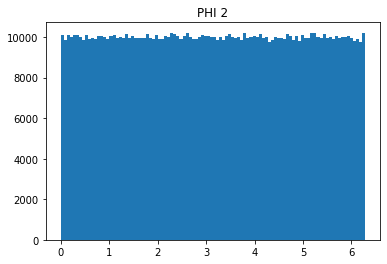

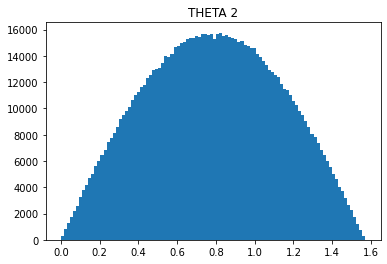

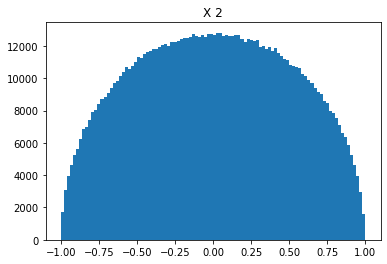

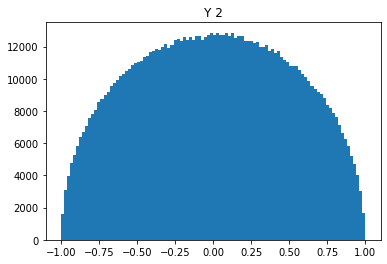

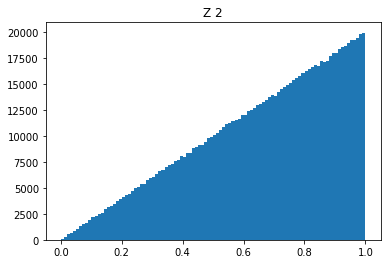

In [24]:
# in-place
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from cupyx import jit

@jit.rawkernel()
def spherical_to_cartesian_raw(theta_z, phi_x, y, size) -> None:
    """in-place reuses the inputs."""
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        y[i] = cp.sin(theta_z[i]) * cp.sin(phi_x[i])
        phi_x[i] = cp.sin(theta_z[i]) * cp.cos(phi_x[i])
        theta_z[i] = cp.cos(theta_z[i])
        
def spherical_to_cartesian(theta: cp.ndarray, phi: cp.ndarray) -> Tuple[cp.ndarray, cp.ndarray, cp.ndarray]:
    x = cp.sin(theta) * cp.cos(phi)
    y = cp.sin(theta) * cp.sin(phi)
    z = cp.cos(theta)
    return (x,y,z)

size = 1000000
# lambertian
phi_x = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
y = cp.empty(size, dtype=np.float32)
theta_z = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title('THETA')
plt.hist(theta_z.get(), bins=100)
plt.show()

# this way makes zero extra temporary columns
spherical_to_cartesian_raw((128,),(1024,),(theta_z, phi_x, y, size))

plt.title('X')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title("Y")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z")
plt.hist(theta_z.get(), bins=100)
plt.show()

# the other way

phi = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
theta = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI 2')
plt.hist(phi.get(), bins=100)
plt.show()

plt.title('THETA 2')
plt.hist(theta.get(), bins=100)
plt.show()

# this way makes two extra temporary columns
(x,y,z) = spherical_to_cartesian(theta, phi)

plt.title('X 2')
plt.hist(x.get(), bins=100)
plt.show()

plt.title("Y 2")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z 2")
plt.hist(z.get(), bins=100)
plt.show()


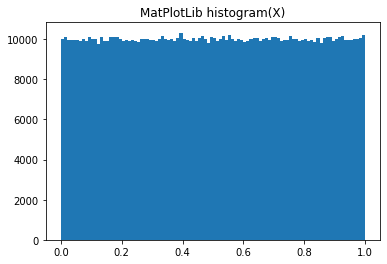

<class 'cupy.ndarray'>
<class 'cupy._core.fusion._FusionVarArray'>
<_FusionVar float32 1-dim array>


TypeError: iteration over a 0-d array

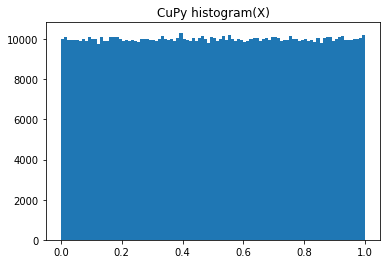

In [48]:
# calculate histograms
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

size = 1000000
x = cp.random.uniform(0, 1, size, dtype=np.float32)
plt.title('MatPlotLib histogram(X)')
plt.hist(x.get(), bins=100)
plt.show()

(hist, bin_edges) = cp.histogram(x, bins=100)
plt.title("CuPy histogram(X)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

@cp.fuse()
def square_hist(y):
    print(type(y))
    print(y)
    return cp.sum((y // 0.2))

print(type(x))
(hist, bin_edges) = square_hist(x)
print(hist)
print(bin_edges)
plt.title("CuPy histogram(X^2)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

# CUDA Histogram
uses shared memory

In [1]:
import cupy as cp
import math
import matplotlib.pyplot as plt
import numpy as np
from cupyx import jit

@jit.rawkernel()
def histogram(input_data: cp.ndarray,
              global_histogram: cp.ndarray,
              size: np.int32,
              min_value: np.float32,
              bin_width: np.float32) -> None:
    """ input_data: cp.ndarray[np.float32]
        global_histogram: cp.ndarray[np.int32]
    """
    # Create a histogram for this block.  Size must match bins and threads.
    block_histogram = jit.shared_memory(np.int32, 128)

    # Alloc is not zeroed so do it.
    block_histogram[jit.threadIdx.x] = 0

    # Wait for all threads to set their zeros.
    jit.syncthreads()
    
    # Fill up the block-local histogram.
    # Adjacent threads get adjacent data:
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    # If there's more than one grid (not recommended) then do that too:
    ntid = jit.gridDim.x * jit.blockDim.x
    
    for i in range(tid, size, ntid):
        bucket_idx = int((input_data[i] - min_value) // bin_width)
        bucket_idx = int(min(max(bucket_idx, 0), 127)) # must match above
        jit.atomic_add(block_histogram, bucket_idx, 1)

    # Wait for all the threads to do it.
    jit.syncthreads()

    # Sum the block-local histograms into a global histogram.
    jit.atomic_add(global_histogram, jit.threadIdx.x, block_histogram[jit.threadIdx.x])

/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
print(f"mempool.used_bytes {mempool.used_bytes()}")

size =100000000
bins = 128

threads_per_block = bins # because the threads write back
grid_size = (int(math.ceil(size / threads_per_block)), 1, 1)
block_size = (threads_per_block, 1, 1)
print(f"grid_size {grid_size}")
print(f"block_size {block_size}")

mempool.used_bytes 0
grid_size (781250, 1, 1)
block_size (128, 1, 1)


In [3]:
epsilon = cp.finfo(np.float32).eps
# [0, pi/2)
y = cp.maximum(0.0, cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32))/2 - epsilon) + 1

In [4]:
print(cp.min(y))
print(cp.max(y))
print(y)
input_min = 1
input_max = np.pi/2 + 1
input_range = input_max - input_min
bin_width = input_range / bins
y_bin = cp.floor_divide(y - input_min, bin_width)
print(y_bin)
print(cp.max(y_bin))
print(cp.min(y_bin))

1.000244
2.5707963
[2.3724651 2.3233418 1.1910428 ... 2.2262135 1.300999  1.8054749]
[111. 107.  15. ...  99.  24.  65.]
127.0
0.0


In [5]:
%%time
# this is about 150us for 100M items (fast!)
h = cp.zeros(bins, dtype=np.int32)
histogram(grid_size, block_size, (y, h, size, np.float32(1), np.float32(np.pi/256)))

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


In [6]:
%%time
# this is like 10ms for 100M items (slow!)
(h2,b2) = cp.histogram(y, bins=256)

CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 28.9 ms


In [7]:
print(cp.sum(h))
print(h)
print(cp.min(h))

100000000
[  15113   45230   75376  105313  135675  165189  194729  224165  254564
  283259  312273  341880  370472  398324  428266  456331  483248  511618
  538953  565562  590558  617767  644223  668559  694302  718779  743444
  767741  789456  812426  836588  858243  879408  897412  918668  940364
  957505  979145  995214 1010781 1029770 1044128 1060626 1076446 1088929
 1102859 1117489 1127804 1139961 1148765 1159644 1168227 1178136 1187741
 1194652 1199617 1204745 1212314 1215666 1218956 1221292 1224384 1226627
 1226520 1227125 1225922 1224658 1223300 1219476 1213806 1213349 1206080
 1199829 1194047 1186002 1175667 1170521 1158791 1150044 1138719 1128528
 1115253 1102717 1089694 1075556 1061010 1045156 1029177 1011431  995082
  977909  956894  938674  920203  899344  877734  857180  835431  812557
  791150  766258  742827  719089  694544  668448  643824  616725  592602
  565618  537586  510189  483905  456565  427415  399939  370885  341955
  312411  284817  254123  224921  194510 

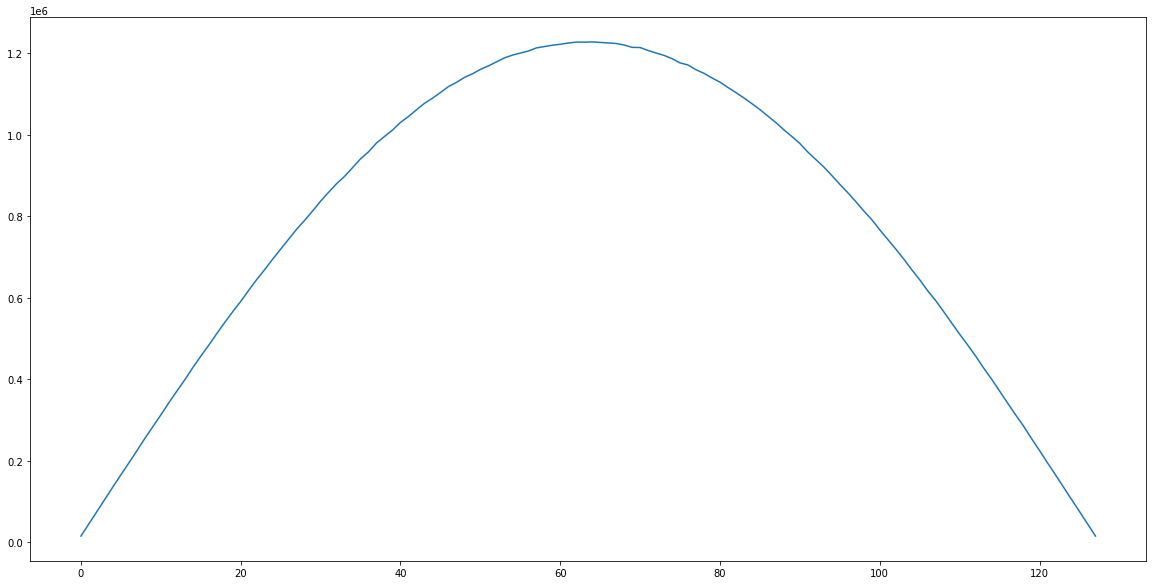

In [8]:
f = plt.figure(figsize=[20, 10])
plt.plot(np.arange(bins), h.get(), snap=False)

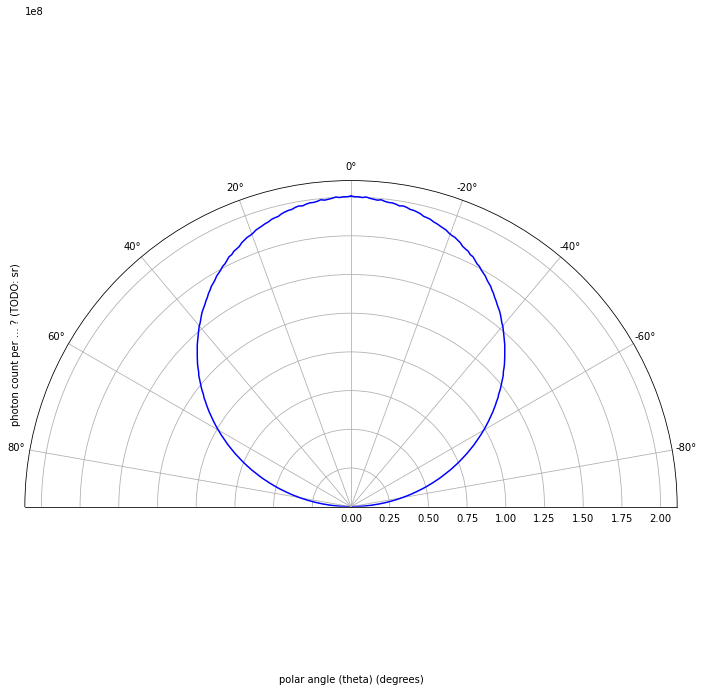

In [9]:
theta_freq = h.get()
theta_range = np.pi/2
theta_min = 0
theta_max = np.pi/2
theta_bins_rad = theta_range * np.arange(bins) / bins + theta_min
theta_bin_width_rad = theta_range / bins
theta_bucket_angle_steradians = np.array(
    list(map(lambda x: (np.cos((theta_range * x + theta_min) / bins)
                      - np.cos((theta_range * (x + 1) + theta_min) / bins)), range(bins),)))

photons_per_steradian_by_theta = theta_freq / theta_bucket_angle_steradians

fig = plt.figure(figsize=[15, 12])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
# mirror the data so it looks nice .. resulting in the weird bounds here
axes.set_thetamin(-theta_max * 180 / np.pi)
axes.set_thetamax(theta_max * 180 / np.pi)
axes.plot(
    theta_bins_rad,
    photons_per_steradian_by_theta,
    color="blue",
    snap=False
)
axes.plot(
    -theta_bins_rad,
    photons_per_steradian_by_theta,
    color="blue",
    snap=False
)
axes.set_xlabel("polar angle (theta) (degrees)")
axes.set_ylabel("photon count per ... ? (TODO: sr)")
plt.show()